<a href="https://colab.research.google.com/github/Gnanigit/Comment_Toxicity/blob/main/Comment_Toxicity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**0 : Install dependencies and Bring data**

In [ ]:
!pip install tensorflow tensorflow-gpu sklearn matplotlib pandas

In [3]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [5]:
df = pd.read_csv(os.path.join('/content/drive/MyDrive/Comment-Toxicity/','train.csv', 'train.csv'))

In [6]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [8]:
df.iloc[0]['comment_text']

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [10]:
df[df['toxic']==1].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [9]:
df[df.columns[2:]].iloc[0]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 0, dtype: int64

**1 : Preprocess**

In [ ]:
!pip list

In [12]:
from tensorflow.keras.layers import TextVectorization

In [15]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [18]:
# x contains comments ,  y contains labels
x = df['comment_text']
y = df[df.columns[2:]].values #numpy array format

In [17]:
MAX_FEATURES = 200000 # number of words in the vocab

In [19]:
# converting wrods to integers
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [ ]:
type(x)

In [23]:
type(x.values)

numpy.ndarray

In [21]:
# learns all the words in x
vectorizer.adapt(x.values)

In [ ]:
# returns vocabulary
vectorizer.get_vocabulary()

In [27]:
# Understanding vectorizer
vectorizer('Hello world, I am good')[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([288, 263,   8,  74,  98])>

In [29]:
vextorized_text = vectorizer(x.values)

In [31]:
len(x)

159571

In [30]:
vextorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [34]:
# Data pipe line generation
# Basic pipeline generation - MSCHBAP = {map, cache, shuffle, batch, prefetch} from_tensor_slices, list_files
dataset = tf.data.Dataset.from_tensor_slices((vextorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps prevent bottlenecks

In [ ]:
dataset.as_numpy_iterator().next()

In [36]:
batch_x, batch_y = dataset.as_numpy_iterator().next()

In [37]:
batch_x.shape

(16, 1800)

In [38]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [42]:
len(train)
len(val)
len(test)

997

In [43]:
train_generator = train.as_numpy_iterator()

In [ ]:
train_generator.next() # it changes batches

**2 : Create sequential data**

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [51]:
model = Sequential()
# create the Embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))

In [52]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                      

In [54]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 11835s 2s/step - loss: 0.0624 - val_loss: 0.0486


In [56]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

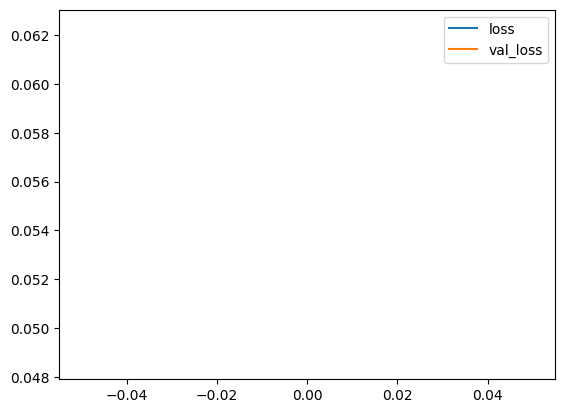

In [57]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

**3 : Make predictions**

In [66]:
input_text= vectorizer('You freaking, suck! I am going to kill you.')

In [64]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [67]:
batch =test.as_numpy_iterator().next()

In [74]:
# batch_x represents to numeric representation of comments
# batch_y represents target cloumn labels , example : [0,0,1,0,1,0] -> {'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'}
batch_x, batch_y = test.as_numpy_iterator().next()

In [75]:
# model.predict(np.expand_dims(input_text,0))
# model.predict(batch_x)
(model.predict(batch_x) >0.5).astype(int)

1/1 [==============================] - 0s 321ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [79]:
res= model.predict(batch_x)

1/1 [==============================] - 0s 184ms/step


In [ ]:
# res

In [83]:
# res.shape

(16, 6)

In [84]:
# res.flatten().shape

(96,)

**4 : Evaluate the model**

In [82]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [81]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  # unpack the patch
  x_true, y_true = batch
  # make a prediction
  yhat = model.predict(x_true)
  # flatten the predictions
  y_true=y_true.flatten()
  yhat=yhat.flatten()

  pre.update_state(y_true, yhat)
  re.update_state(y_true, yhat)
  acc.update_state(y_true, yhat)



In [86]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8479381203651428, Recall:0.6339113712310791, Accuracy:0.4653961956501007


**5 : Test and Gradio**

In [ ]:
!pip install gradio jinja2

In [103]:
import gradio as gr
import tensorflow as tf

In [ ]:
model.save('toxocity.h5')

In [104]:
model=tf.keras.models.load_model('toxocity.h5')

In [105]:
input_str = vectorizer('hey i freaken hate you! I am coming for you. I\'m going to hurt you!')

In [106]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 1s/step


In [107]:
res >0.5

array([[ True, False, False, False, False, False]])

In [108]:
res

array([[0.6607401 , 0.0072197 , 0.1499273 , 0.01145116, 0.19174035,
        0.0299721 ]], dtype=float32)

In [109]:
def score_comment(comment):
  vectorized_comment = vectorizer([comment])
  results = model.predict(vectorized_comment)

  text = ''
  for idx, col in enumerate(df.columns[2:]):
    text += '{}: {}\n'.format(col, results[0][idx]>0.5)
  return text


In [111]:
interface = gr.Interface(fn=score_comment,
                       inputs=gr.Textbox(lines=2, placeholder='Comment to score'), # The Textbox object is now accessed directly from the gradio module.
                       outputs='text')

In [112]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://1aa5a79561de7c4ff1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
